In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random as random
import cPickle as pickle
from scipy import linalg

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('mimic/PATIENT_VISIT_FULL.csv',sep=',')
data.head(10)

,subject_id,hadm_id,admittime,icd9_code
0,17,194023,2134-12-27,"7,24,29,187"
1,17,161087,2135-05-09,"24,197,39,46,7,34,128,163"
2,23,152223,2153-09-03,"1,7,8,11,30,74,104,260"
3,23,124321,2157-10-18,"23,30,31,60,264,1,7,11"
4,34,115799,2186-07-18,"17,33,37,52,106,3,4,8"
5,34,144319,2191-02-23,"3,4,8,14,21,106,141"
6,36,182104,2131-04-30,"1,8,15,18,27,32,74,104,154"
7,36,122659,2131-05-12,"1,8,11,15,18,19,26,27,74,78,124"
8,36,165660,2134-05-10,"114,124,1,8,9,18,27,28,33,49,74"
9,68,170467,2173-12-15,"3,5,6,10,12,28,52,89,111,149,312,354"


In [3]:
data['icd9']=map(lambda x:map(int,x.split(',')),data.icd9_code)
data.head(10)

,subject_id,hadm_id,admittime,icd9_code,icd9
0,17,194023,2134-12-27,"7,24,29,187","[7, 24, 29, 187]"
1,17,161087,2135-05-09,"24,197,39,46,7,34,128,163","[24, 197, 39, 46, 7, 34, 128, 163]"
2,23,152223,2153-09-03,"1,7,8,11,30,74,104,260","[1, 7, 8, 11, 30, 74, 104, 260]"
3,23,124321,2157-10-18,"23,30,31,60,264,1,7,11","[23, 30, 31, 60, 264, 1, 7, 11]"
4,34,115799,2186-07-18,"17,33,37,52,106,3,4,8","[17, 33, 37, 52, 106, 3, 4, 8]"
5,34,144319,2191-02-23,"3,4,8,14,21,106,141","[3, 4, 8, 14, 21, 106, 141]"
6,36,182104,2131-04-30,"1,8,15,18,27,32,74,104,154","[1, 8, 15, 18, 27, 32, 74, 104, 154]"
7,36,122659,2131-05-12,"1,8,11,15,18,19,26,27,74,78,124","[1, 8, 11, 15, 18, 19, 26, 27, 74, 78, 124]"
8,36,165660,2134-05-10,"114,124,1,8,9,18,27,28,33,49,74","[114, 124, 1, 8, 9, 18, 27, 28, 33, 49, 74]"
9,68,170467,2173-12-15,"3,5,6,10,12,28,52,89,111,149,312,354","[3, 5, 6, 10, 12, 28, 52, 89, 111, 149, 312, 354]"


In [4]:
SAMPLE_SIZE = data.shape[0]
FEATURE_SIZE = 829    

In [5]:
# matrix padding, convert list of codes to matrix
code_matrix = np.zeros([SAMPLE_SIZE,FEATURE_SIZE])
for i in range(SAMPLE_SIZE):
    for c in data.icd9[i]:
        code_matrix[i,c-1] = 1

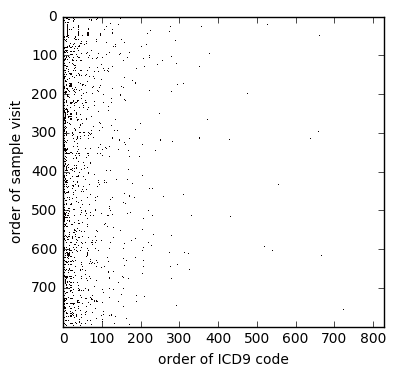

In [6]:
# heatmap of matrix slice
plt.imshow(-code_matrix[:800],cmap='hot',interpolation='nearest')
plt.xlabel('order of ICD9 code')
plt.ylabel('order of sample visit')

In [7]:
############ auto-encoder ############
# initialize weight and intercept for neural network
def initializeWeight(input_size, output_size):
    # dim - [input_size, output_size]
    weight = tf.Variable(tf.truncated_normal([input_size, output_size],stddev=0.1))
    # dim - [output_size]
    bias = tf.Variable(tf.constant(0.1, shape=[output_size]))
    return weight,bias

# set up the network structure for auto-encoder
def autoEncoder(features, hidden = 200, Lambda = 0.1):
    # output layer is the same as input layer
    classes = features
    
    # input of the network
    input_layer = tf.placeholder(tf.float32,[None,features])
    
    # hidden layer
    W,b = initializeWeight(features,hidden)
    hidden_layer = tf.nn.tanh(tf.matmul(input_layer, W) + b)
    
    # output layer, using W^T
    W_t = tf.transpose(W)
    b_t = tf.Variable(tf.constant(0.1, shape=[classes]))
    output_layer = tf.nn.sigmoid(tf.matmul(hidden_layer, W_t) + b_t)
    
    # loss function
    loss = tf.reduce_mean(tf.square(output_layer-input_layer)) + \
            Lambda * tf.reduce_mean(tf.square(W_t))
    
    # error compared with other methods
    loss_abs = tf.reduce_mean(tf.abs(output_layer-input_layer)) 
    return input_layer,output_layer,loss,loss_abs

# train auto-encoder
def trainAutoEncoder(data,steps,batch,dimension = 200,alpha=0.01,Lambda = 0.1,PRINT=0):
    x,x_hat,loss,loss_abs = autoEncoder(data.shape[1],dimension,Lambda)
    optimizer = tf.train.AdamOptimizer(alpha).minimize(loss)

    n = data.shape[0]
    session = tf.Session()
    session.run(tf.initialize_all_variables())

    for epoch in range(steps):
        index = random.sample(range(n),batch)
        x_training = np.array(data[index,:])
        loss_,loss_abs_, x_hat_ = session.run([loss,loss_abs,x_hat],\
                                              feed_dict={x: x_training})
        # print "Epoch %d, train error: %.2f, accuracy: %.4f"% (epoch, loss_,accuracy_)
        if PRINT:
            print 'x',x_training
            print 'x_hat',x_hat_
            
    return loss_,loss_abs_

In [8]:
############ PCA ############
def PCA(data, dimension=10):
    sample_size,feature_size = data.shape
    
    # centered data
    data -= data.mean(axis=0)
    # covariance matrix
    covariance = np.cov(data, rowvar=False)
    
    # calculate eigenvectors and eigenvalues of covariance
    evals, evecs = linalg.eigh(covariance)
    
    # sort eigenvectors and eigenvalues according to eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    
    # select the first n eigenvectors
    evecs = evecs[:, :dimension]
    
    # transformed data
    data_pca = data.dot(evecs)
    
    return data_pca, evals, evecs

In [9]:
# calculate error 
def getError(pred,data):
    return np.mean(np.abs(pred-data))

# calculate error for first elements as main components
def getErrorFirstElements(data,dimension_set):
    error = []
    data_first_elements = data.copy()

    for d in dimension_set[::-1]:
        # get first elements as main components
        data_first_elements[:,d+1:] = np.zeros(data_first_elements[:,d+1:].shape)
        # compare main components and data
        error.append(getError(data_first_elements,data))
    return error

# calculate error for pca 
def getErrorPCA(data,dimension_set):
    error = []
    for d in dimension_set:
        # get PCA of data and prediction accordingly
        data_pca, evals, evecs = PCA(data,d)
        data_pca_prediction = data_pca.dot(evecs.T)

        # compare prediction and data
        data_zero_mean = data - np.mean(data,axis=0)
        error.append(getError(data_pca_prediction,data_zero_mean))
    return error

# calculate error for auto-encoder
def getErrorAutoEncoder(data,dimension_set,alpha_set=[0.03],lambda_set=[0.1]):
    BATCH_SIZE = 500
    EPOCH_STEPS = 100
    PRINT = 0

    error = {}
    for alpha in alpha_set:
        for Lambda in lambda_set:
            for dim in dimension_set:
                print 'process alpha = ' + str(alpha) + \
                        ', lambda = ' + str(Lambda) + \
                        ', dimension = ' + str(dim)
                error[(alpha,Lambda,dim)] = trainAutoEncoder(data,EPOCH_STEPS,BATCH_SIZE,\
                                                           dim,alpha,Lambda,PRINT)
                print error[(alpha,Lambda,dim)]
    return error


In [10]:
columns = FEATURE_SIZE
slice_data = code_matrix[:,:columns]

iteration = 50
dimension_set = [i*iteration for i in range(1,columns//iteration)]

columns = FEATURE_SIZE
slice_data = code_matrix[:,:columns]

In [11]:
# optimal hyper parameter
alpha_set = [0.01,0.03,0.1,0.3]
lambda_set = [0.01,0.1,1]

error_auto_encoder = getErrorAutoEncoder(slice_data,dimension_set,\
                                         alpha_set,lambda_set).values()


process alpha = 0.01, lambda = 0.01, dimension = 50
(0.27637249, 0.52341378)
process alpha = 0.01, lambda = 0.01, dimension = 100
(0.27717608, 0.52201939)
process alpha = 0.01, lambda = 0.01, dimension = 150
(0.27974004, 0.52260214)
process alpha = 0.01, lambda = 0.01, dimension = 200
(0.27998918, 0.52013487)
process alpha = 0.01, lambda = 0.01, dimension = 250
(0.28068289, 0.51958662)
process alpha = 0.01, lambda = 0.01, dimension = 300
(0.28184316, 0.51821119)
process alpha = 0.01, lambda = 0.01, dimension = 350
(0.28164014, 0.51635271)
process alpha = 0.01, lambda = 0.01, dimension = 400
(0.28658265, 0.51924121)
process alpha = 0.01, lambda = 0.01, dimension = 450
(0.28254995, 0.51323712)
process alpha = 0.01, lambda = 0.01, dimension = 500
(0.28685704, 0.51668453)
process alpha = 0.01, lambda = 0.01, dimension = 550
(0.28800178, 0.51500857)
process alpha = 0.01, lambda = 0.01, dimension = 600
(0.29005826, 0.51591635)
process alpha = 0.01, lambda = 0.01, dimension = 650
(0.29227215,

180


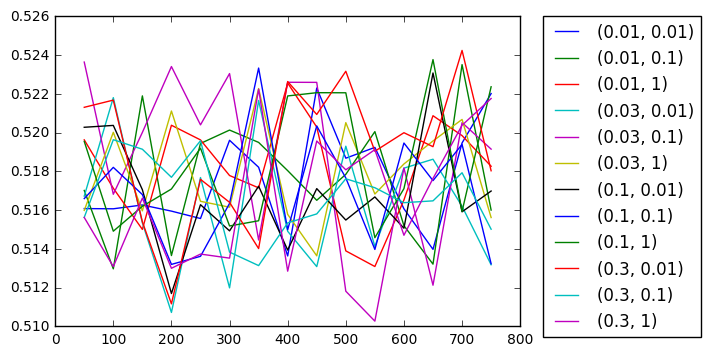

In [23]:
print len(error_auto_encoder)
leg = [(alpha,Lambda) for alpha in alpha_set for Lambda in lambda_set]
l = len(leg)
error = []
for i in range(l):
    valid = map(lambda x: x[1],
               error_auto_encoder[i*len(dimension_set):(i+1)*len(dimension_set)])
    plt.plot(dimension_set,valid)
    error.append(np.mean(valid))
plt.legend(leg,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

index = np.argsort(error)[0]
error_auto_encoder = map(lambda x: x[1],
                       error_auto_encoder[index*len(dimension_set):\
                                          (index+1)*len(dimension_set)])

In [24]:
error_first_element = getErrorFirstElements(slice_data,dimension_set)
error_pca = getErrorPCA(slice_data,dimension_set)

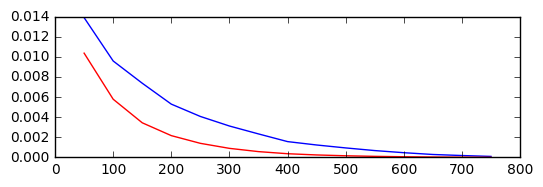

In [25]:
plt.subplot(212)
plt.plot(dimension_set,error_pca,color = 'blue')
plt.plot(dimension_set[::-1],error_first_element,color = 'red')

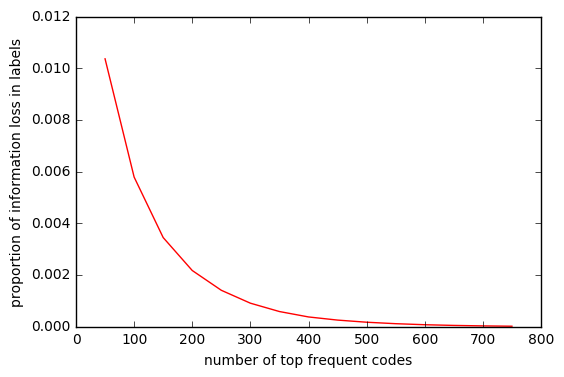

In [26]:
plt.plot(dimension_set[::-1],error_first_element,color = 'red')
plt.xlabel('number of top frequent codes')
plt.ylabel('proportion of information loss in labels')

In [27]:
_,_,embedding_matrix = PCA(slice_data,200)
pickle.dump(embedding_matrix,open('data/embedding_matrix_200','wr'))
_,_,embedding_matrix = PCA(slice_data,400)
pickle.dump(embedding_matrix,open('data/embedding_matrix_400','wr'))

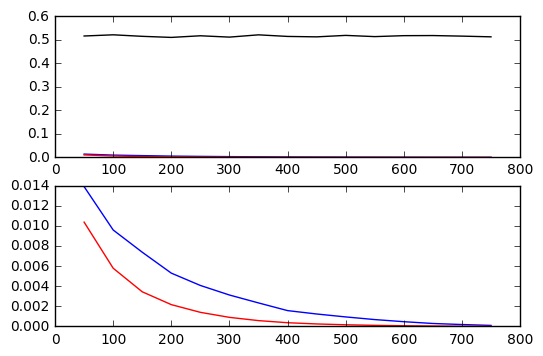

In [28]:
plt.subplot(211)
plt.plot(dimension_set,error_auto_encoder,color = 'black')
plt.plot(dimension_set,error_pca,color = 'blue')
plt.plot(dimension_set[::-1],error_first_element,color = 'red')
plt.subplot(212)
plt.plot(dimension_set,error_pca,color = 'blue')
plt.plot(dimension_set[::-1],error_first_element,color = 'red')